# Forward dynamics of infection on Zachary’s karate club data
Comparison with Fig. 2 in *Ortega et. al*, [Dynamics of epidemics from cavity master equations: Susceptible-infectious-susceptible models](https://doi.org/10.1103/PhysRevE.105.024308)

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [2]:
# read matrix of contacts, found at http://konect.cc/networks/ucidata-zachary/
A = readdlm("karate.txt", Bool)
g = IndexedGraph(A);

In [3]:
N = nv(g)  # number of individuals
T = 50     # final time
ΔT = 0.8   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery

# prob. of being infected at time zero
p⁰ = map(1:N) do i
   if i == 1
        [0.0, 1.0]   # node 1 is infected at time zero
    else
        [1.0, 0.0]   # all other nodes start as susceptible
    end
end

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*ΔT, ρ*ΔT, floor(Int, T/ΔT); p⁰)

# set up MPBP computation
bp = mpbp(sis);

In [4]:
svd_trunc = TruncBond(8)   # maximum matrix size for SVD-based truncation
maxiter = 10
tol = 1e-3

# run MPBP
iters, cb = iterate!(bp; svd_trunc, maxiter, tol);

In [5]:
if iters < maxiter
    println("BP converged after $iters iterations")
else
    println("BP did not meet criteria for convergence after $maxiter iterations")
end

BP converged after 1 iterations


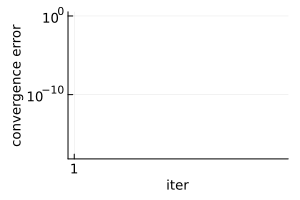

In [6]:
plot(cb.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="", xticks=1:iters)

In [7]:
# compute marginals
b_bp = beliefs(bp)
p29_bp = [bb[INFECTED] for bb in b_bp[29]];

In [8]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [9]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
nsamples_mc = 10^5
sample!(sms, nsamples_mc)
b_mc = marginals(sms)
p29_mc = [bb[INFECTED] for bb in b_mc[29]];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:01:15m


In [10]:
pl = plot(xlabel="time", xticks=0:10:T, ylabel="\$P(x_{29}^t=I)\$", ylims=(-0.05,1), legend=:bottomright)
plot!(pl, 0:ΔT:T, p29_bp, m=:o, ms=2, label="MPBP")
plot!(pl, 0:ΔT:T, p29_mc, m=:x, ms=2, label="MC")
ylims = extrema((p29_bp[end], p29_mc[end].val)) .+ (-1, 1) .* 0.05
plot!(pl, xticks=T-20:4:T, ylims=ylims, xlims=(T-20,T),
    inset=(1, bbox(0.5, 0.3, 0.45, 0.4)), subplot=2)
plot!(pl[2], 0:ΔT:T, p29_bp, m=:o, ms=2, label="")
plot!(pl[2], 0:ΔT:T, p29_mc, m=:x, ms=2, label="");

In [11]:
pl_err = plot(xlabel="time", xticks=0:10:T, ylims=(-0.01,0.3))
plot!(pl_err, 0:ΔT:T, abs.(p29_bp.-p29_mc), label="", ylabel="L₁-error");

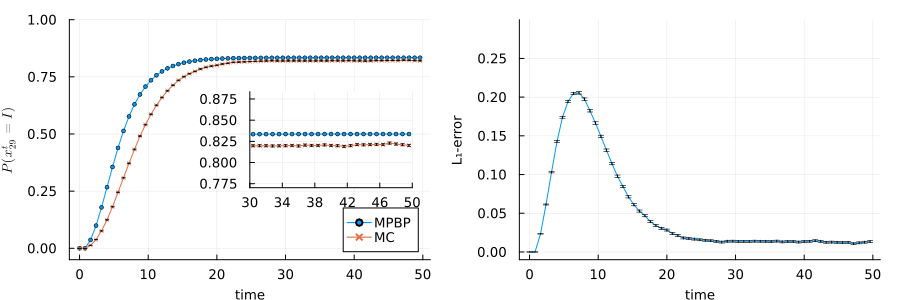

In [12]:
plot(pl, pl_err, size=(900,300), margin=3Plots.mm)

Compare with:

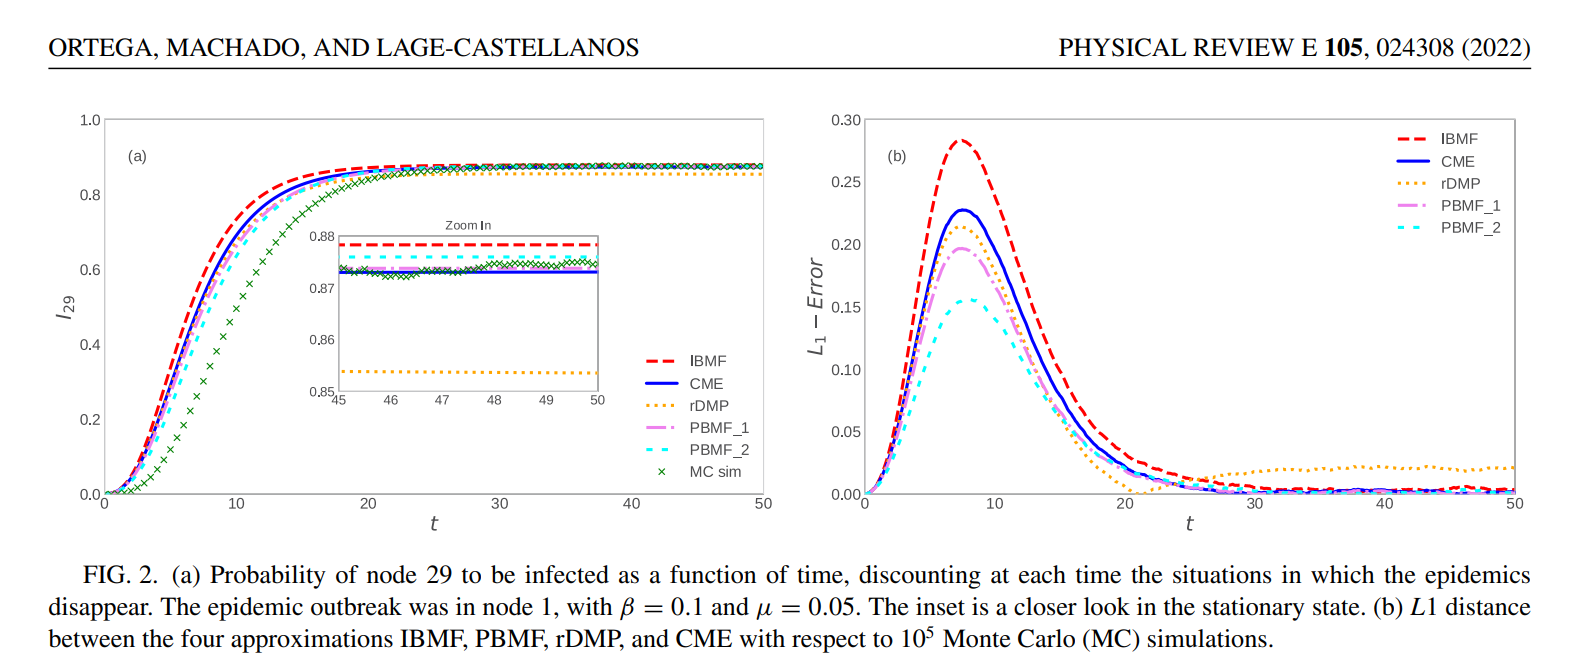

In [18]:
c = autocovariances(bp; svd_trunc);

In [38]:
using ColorSchemes
function plot_autocovs(c, T; skip_even=true, kw...)
    step = skip_even ? 2 : 1
    us = 20:10:T
    cg = cgrad(:matter, length(us), categorical=true)
    ylabel = "\$\\langle x_{29}^t x_{29}^{t+\\Delta t}\\rangle-" * 
        "\\langle x_{29}^t\\rangle\\langle x_{29}^{t+\\Delta t}\\rangle \$"
    xlabel = "\$\\Delta t \$"
    pl = plot(;xlabel, ylabel, legend=:outertopright, 
        title="SIS karate club. λ = $λ, ρ = $ρ")
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-step:1, c[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
    end
    pl
end  

plot_autocovs (generic function with 1 method)

In [39]:
c29 = map(x -> x > 0 ? x : 1e-17, c[29]);

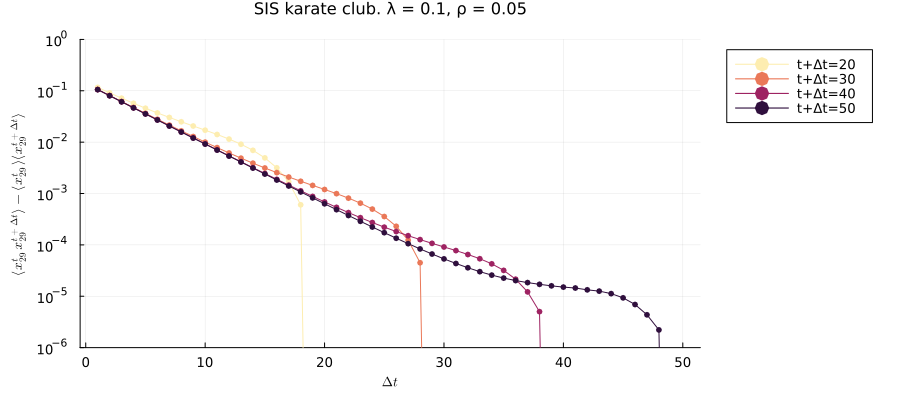

In [40]:
pl_autocov = plot_autocovs(c29, T; skip_even=false, yaxis=(:log10, (1e-6,1e-0)), 
    size=(900,400), margin=5Plots.mm)